<a href="https://colab.research.google.com/github/tsayula/Capstone/blob/main/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ship Image Classification using Neural Networks 

##Overview

Among growing tension worldwide, there are a range of problems surfacing off the shores of virtually every ocean-adjacent country. 
This include overfishing, piracy, military encroachment, and the violation of exclusive economic zones. Billions of dollars are lost every year in an effort to combat these issues.  

##Business Problem/Use Case

Naturally, the ability to recognize and distinguish different kinds of ships can go a long way in preventing or at least more efficently dealing with these types of problems. 
The goal of this project is to be able to correctly identify the type of marine vessel based on the image using Convolutional Neural Networks.



##Data Understanding

The data consisted of a total of 6,252 images from Kaggle. The target variable is broken down into 5 categories.

Convolutional Neural Network (CNN) models will be created in order to train on the datal. These models will be evalued using accuracy scores to stress the 
importance of minimizing false positives. In this case false postiive could be determinal to a high stakes situation where a carrier ship is incorrectly identified as a military ship which could lead to disastrous consequences.


____

###Mounting the Drive to load the data

In [193]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [194]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [195]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [196]:
#downloading the data from Kaggle

# !kaggle datasets download -d arpitjain007/game-of-deep-learning-ship-datasets

In [197]:
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip


In [198]:
!ls

kaggle.json		       training_val_accuracy_sm.png
sample_submission_ns2btKE.csv  training_val_accuracy_vgg16.png
test_ApKoW4T.csv	       training_val_loss_vgg16.png
train			       vgg16_1.h5


In [199]:
import pandas as pd
import numpy as np
import keras_preprocessing.image

In [200]:
import sys
import os
import random
from pathlib import Path

In [201]:
# Image Processing
import imageio
import cv2
import skimage.transform

# Charts
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')
%matplotlib inline


# ML, Statistics
import scipy
import tensorflow as tf
from tensorflow import data
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

In [202]:
from google.colab.patches import cv2_imshow

In [203]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Pretrained models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16

##Data Preparation


*   Import Data
*   Create Directory for data
*   Examine images











In [204]:
import os
print(os.listdir("/content/gdrive/My Drive/Kaggle"))

['sample_submission_ns2btKE.csv', 'test_ApKoW4T.csv', 'kaggle.json', 'train', 'training_val_accuracy_sm.png', 'vgg16_1.h5', 'training_val_accuracy_vgg16.png', 'training_val_loss_vgg16.png']


In [205]:

ship_images= (os.listdir("/content/gdrive/My Drive/Kaggle/train/images"))


In [206]:
#lets see what our data looks like
ship_labels= pd.read_csv('train/train.csv')
ship_labels.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [207]:

ship_labels.head(5)

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [208]:
#examining class imbalance
ship_labels['category'].value_counts()

1    2120
5    1217
2    1167
3     916
4     832
Name: category, dtype: int64

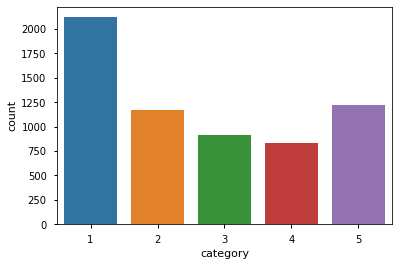

In [209]:
# Visualizing class imbalance
sns.countplot(x='category' , data=train_df);

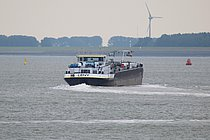

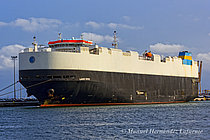

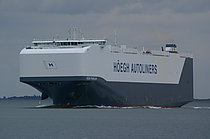

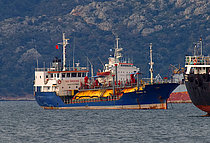

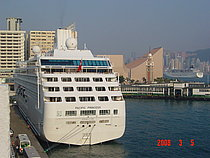

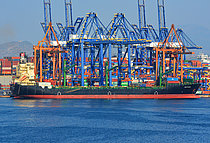

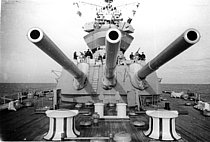

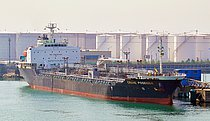

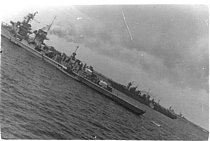

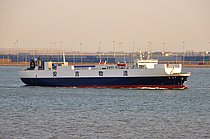

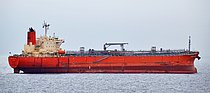

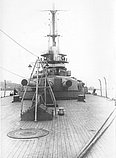

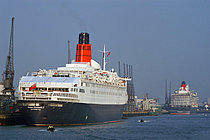

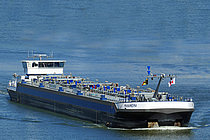

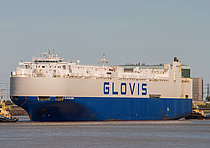

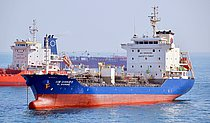

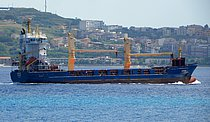

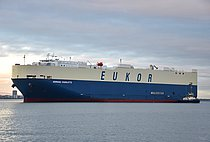

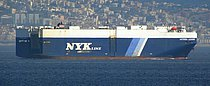

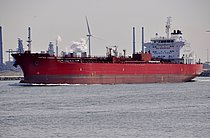

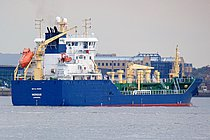

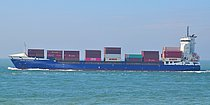

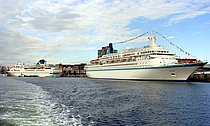

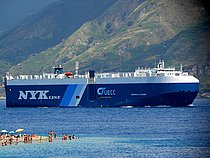

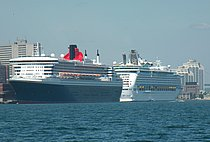

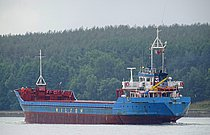

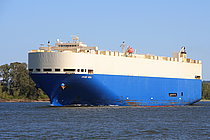

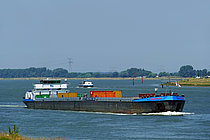

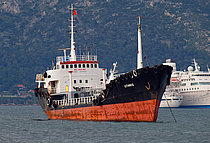

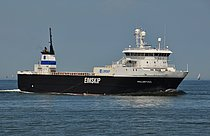

In [227]:
#lets take a look at some of the images in the dataset
ship_images
for i in ship_images[:30]:
  y = cv2.imread('/content/gdrive/My Drive/Kaggle/train/images/'+i , 1)
  cv2_imshow(y)

In [211]:
ships_dict= {'Cargo': 0, 
'Military': 1, 
'Carrier': 2, 
'Cruise': 3, 
'Tankers': 4}

In [224]:
ships_dict

{0: 'Cargo', 1: 'Military', 2: 'Carrier', 3: 'Cruise', 4: 'Tankers'}

In [212]:

for k,v in ships_dict.items():
  print(k)

Cargo
Military
Carrier
Cruise
Tankers


In [213]:

ships_dict= {k:v for v,k in ships_dict.items()}
ships_dict

{0: 'Cargo', 1: 'Military', 2: 'Carrier', 3: 'Cruise', 4: 'Tankers'}

##Splitting Data into Train and Validations Sets
In order to set up the our Deep Learning models, we need to first do a train test split so that we have a way to validate the models. Although we will create training and testing dataframe, for now we will only be using the training set to do a train test split, as the test set from Kaggle doesnt include labels. Then a data generator will be created where to can properly rescale the images as well as set aside 25% (1563) of the data to serve as our validation set.

In [214]:
train_df= pd.read_csv("train/train.csv", dtype= str)
test_df= pd.read_csv('test_ApKoW4T.csv', dtype= str)

src_path_train= '/content/gdrive/My Drive/Kaggle/train/images'

# train_df['image']= train_df['image'].apply(append_extension)
# test_df['image']= test_df['image'].apply(append_extension)

data_generator= ImageDataGenerator(rescale= 1./255., validation_split=0.25)

Here we create our generators for our train and validation sets, which are specified by the subset parameter. If we want to augment the images in the future we will need to be sure to create a seperate data_generator to be used only on the training set, as we do not want to augment images in our validation set too.

In [257]:
train_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category', subset= 'training', target_size=(64, 64),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category', subset= 'validation', target_size=(64,64),
     batch_size= 29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)

# test_data_generator= ImageDataGenerator(rescale= 1./255.)

# test_generator= data_generator.flow_from_dataframe(
#     dataframe= test_df, directory= 'test_ApKoW4T.csv', x_col='image', y_col= None, subset= 'validation', target_size=(64,64),
#      batch_size= 29, seed= 42, shuffle= False,  class_mode= None, validate_filenames=False
# )

Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


In [216]:
#Examining the classes
train_generator.labels[:10]
lst=train_generator.labels

In [217]:
#examining the Classes
train_generator.class_indices

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}

In [218]:
lstval = list(map(ships_dict.get, lst))
lstval[:10]

['Military',
 'Military',
 'Military',
 'Tankers',
 'Carrier',
 'Cargo',
 'Cruise',
 'Carrier',
 'Military',
 'Cargo']

In [219]:
imgs, lbl = next(iter(train_generator))

##First CNN Simple Model
 The following code creates a function which contains our first simple model. Optimizes for accuracy, and the output layer uses the sigmoid activation just to see what results we get (the following models will all employ softmax at the output layers).
 

In [220]:
def prepare_model():
  model= Sequential()
  model.add(Conv2D(32, kernel_size= (3,3), activation='relu', input_shape=(64,64,3)))
  model.add(Flatten())
  model.add(Dense(5, activation= 'sigmoid'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model


In [221]:
simple_model= prepare_model()
simple_model.fit(train_generator, 
                    validation_data= validation_generator,
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size,
                    epochs= 3  
                    )

Epoch 1/3
161/161 [==============================] - 12s 70ms/step - loss: 2.0883 - accuracy: 0.3742 - val_loss: 1.1404 - val_accuracy: 0.5686
Epoch 2/3
161/161 [==============================] - 10s 64ms/step - loss: 0.8269 - accuracy: 0.7172 - val_loss: 1.0884 - val_accuracy: 0.5901
Epoch 3/3
161/161 [==============================] - 10s 61ms/step - loss: 0.4979 - accuracy: 0.8560 - val_loss: 1.1041 - val_accuracy: 0.5836


In [222]:
simple_model.history.history

{'accuracy': [0.45643776655197144, 0.7142857313156128, 0.8521459102630615],
 'loss': [1.491443157196045, 0.8094435334205627, 0.48957812786102295],
 'val_accuracy': [0.5686402320861816, 0.5901105999946594, 0.5836043953895569],
 'val_loss': [1.1403604745864868, 1.0883731842041016, 1.1041247844696045]}

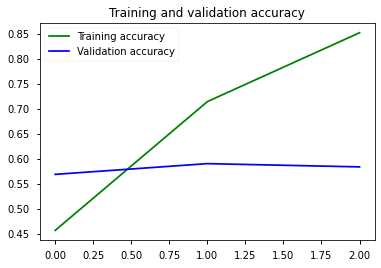

<Figure size 432x288 with 0 Axes>

In [223]:
acc= simple_model.history.history
acc = simple_model.history.history['accuracy']
val_acc = simple_model.history.history['val_accuracy']
loss = simple_model.history.history['loss']
val_loss = simple_model.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_sm')
plt.show();

As we can see from the graph above, clearly our model is overfitting, giving the high training accuracy and low validation accuracy. 



## Model 2

This next model will use 'softmax' activation at the output layer instead of 'sigmoid' activation to see if accuracy improves, since softmax does better than sigmoid with multiclass problems. We will also let it train longer at 10 epochs.

In [228]:
def prepare_model():
  model= Sequential()
  model.add(Conv2D(32, kernel_size= (3,3), activation='relu', input_shape=(64,64,3)))
  model.add(Flatten())
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model


In [229]:
model_2= prepare_model()
model_2.fit(train_generator, 
                    validation_data= validation_generator,
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size,
                    epochs= 10  
                    )

Epoch 1/10
161/161 [==============================] - 11s 64ms/step - loss: 3.8537 - accuracy: 0.3254 - val_loss: 1.1396 - val_accuracy: 0.5413
Epoch 2/10
161/161 [==============================] - 10s 62ms/step - loss: 0.8392 - accuracy: 0.6971 - val_loss: 1.1192 - val_accuracy: 0.5537
Epoch 3/10
161/161 [==============================] - 10s 61ms/step - loss: 0.5660 - accuracy: 0.8276 - val_loss: 1.1745 - val_accuracy: 0.5654
Epoch 4/10
161/161 [==============================] - 10s 62ms/step - loss: 0.3638 - accuracy: 0.9058 - val_loss: 1.1914 - val_accuracy: 0.5953
Epoch 5/10
161/161 [==============================] - 11s 66ms/step - loss: 0.2352 - accuracy: 0.9501 - val_loss: 1.1436 - val_accuracy: 0.5973
Epoch 6/10
161/161 [==============================] - 11s 67ms/step - loss: 0.1430 - accuracy: 0.9816 - val_loss: 1.2641 - val_accuracy: 0.5986
Epoch 7/10
161/161 [==============================] - 10s 62ms/step - loss: 0.0886 - accuracy: 0.9926 - val_loss: 1.3160 - val_accuracy:

In [230]:
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
flatten_14 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 615045    
Total params: 615,941
Trainable params: 615,941
Non-trainable params: 0
_________________________________________________________________


The training accuracy improved from 80% to 99%! However definitely still overfitting. 




##Model 3

Adding some more layers. We might have to sacrifice some training accuracy in order to improve our validation accuracy and stop overfitting.

In [231]:
def prepare_model_3():
  model= Sequential()
  model.add(Conv2D(32, kernel_size= (3,3), activation='relu', input_shape=(64,64,3)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model

In [232]:
#lets try 15 epochs this time
model_3= prepare_model_3()
model_3.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=15)



Epoch 1/15
161/161 [==============================] - 12s 68ms/step - loss: 1.4333 - accuracy: 0.3889 - val_loss: 1.1768 - val_accuracy: 0.5394
Epoch 2/15
161/161 [==============================] - 11s 67ms/step - loss: 1.0591 - accuracy: 0.5715 - val_loss: 1.0114 - val_accuracy: 0.6012
Epoch 3/15
161/161 [==============================] - 10s 65ms/step - loss: 0.9386 - accuracy: 0.6267 - val_loss: 0.9953 - val_accuracy: 0.6070
Epoch 4/15
161/161 [==============================] - 10s 64ms/step - loss: 0.8039 - accuracy: 0.6821 - val_loss: 0.9360 - val_accuracy: 0.6402
Epoch 5/15
161/161 [==============================] - 10s 62ms/step - loss: 0.7060 - accuracy: 0.7222 - val_loss: 0.8487 - val_accuracy: 0.6753
Epoch 6/15
161/161 [==============================] - 10s 61ms/step - loss: 0.6027 - accuracy: 0.7695 - val_loss: 0.8435 - val_accuracy: 0.6792
Epoch 7/15
161/161 [==============================] - 10s 63ms/step - loss: 0.5416 - accuracy: 0.7955 - val_loss: 0.8292 - val_accuracy:

In comparison to Model 2, Model 3 has added a couple more covolutional layers on which to train on. Additionally Model 3 ran for 15 epochs, reaching a 
training accuracy of 99% and validation acc of roughly 70%.

The model is still overfitting. However at least the validation accurary has improved by 10%. 




________

##Model 4

Lets make this CNN a little deeper and add some more hidden layers...

In [233]:
def prepare_model_4():
  model= Sequential()
  #Layer 1
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu', input_shape=(64,64,3)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  #Layer 2
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  #Layer 3
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  #Layer 4
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  #Layer 5
  model.add(Dense(512, activation= 'relu'))
  #Layer 6
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model

In [234]:
model_4= prepare_model_4()
model_4.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=20)

Epoch 1/20
161/161 [==============================] - 12s 67ms/step - loss: 1.5195 - accuracy: 0.3485 - val_loss: 1.2784 - val_accuracy: 0.4476
Epoch 2/20
161/161 [==============================] - 10s 64ms/step - loss: 1.1418 - accuracy: 0.5183 - val_loss: 1.0591 - val_accuracy: 0.5348
Epoch 3/20
161/161 [==============================] - 10s 65ms/step - loss: 0.9556 - accuracy: 0.5965 - val_loss: 0.9175 - val_accuracy: 0.6363
Epoch 4/20
161/161 [==============================] - 10s 63ms/step - loss: 0.8098 - accuracy: 0.6596 - val_loss: 0.7881 - val_accuracy: 0.6753
Epoch 5/20
161/161 [==============================] - 11s 68ms/step - loss: 0.7431 - accuracy: 0.6983 - val_loss: 0.7507 - val_accuracy: 0.7092
Epoch 6/20
161/161 [==============================] - 11s 69ms/step - loss: 0.6583 - accuracy: 0.7461 - val_loss: 0.6710 - val_accuracy: 0.7339
Epoch 7/20
161/161 [==============================] - 11s 66ms/step - loss: 0.5505 - accuracy: 0.7870 - val_loss: 0.6754 - val_accuracy:

In comparison to Model 3, Model 4 has added a couple more covolutional layers on which to train on. Additionally Model 4 ran for 20 epochs, reaching a 
training accuracy of 99% and validation acc of 78%.

The model is still overfitting. However at least the validation accurary has improved by 8%. 

Next lets try adding some regularization layers in order to prevent the model from overfitting. To help curb this issue we will add some dropout layers.



##Model 5


Next lets try adding some regularization layers in order to prevent the model from overfitting. To help curb this issue we will add some dropout layers.

In [235]:
#create early stopping with a patience of 10 and saving our best model
cnn_early_stop= [EarlyStopping(monitor='val_loss', patience= 10), 
                 ModelCheckpoint(filepath='/content/gdrive/My Drive/Capstone/best_models/', monitor='val_loss', save_best_only=True)]

In [236]:
def prepare_model_5():
  model= Sequential()
  #Layer 1
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu', input_shape= (64,64,3)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.1))
  #Layer 2
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.1))
  #Layer 3
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.1))
  #Layer 4
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  #Layer 5
  model.add(Dense(512, activation= 'relu'))
  #Layer 6
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model

In [237]:
model_5= prepare_model_5()
model_5.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=20, callbacks= cnn_early_stop
            
            )

Epoch 1/20
161/161 [==============================] - 13s 71ms/step - loss: 1.5511 - accuracy: 0.3274 - val_loss: 1.3977 - val_accuracy: 0.3429
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 2/20
161/161 [==============================] - 11s 69ms/step - loss: 1.2935 - accuracy: 0.4265 - val_loss: 1.1415 - val_accuracy: 0.5205
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 3/20
161/161 [==============================] - 10s 64ms/step - loss: 1.0915 - accuracy: 0.5398 - val_loss: 1.0278 - val_accuracy: 0.5680
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 4/20
161/161 [==============================] - 10s 63ms/step - loss: 0.9482 - accuracy: 0.6126 - val_loss: 0.9071 - val_accuracy: 0.6344
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 5/20
161/161 [==============================] - 10s 65ms/step - loss: 0.8538 - accuracy: 0.6408 - val_loss: 0.7749 - val_accuracy: 0.6779
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 6/20
161/161 [==============================] - 11s 68ms/step - loss: 0.7241 - accuracy: 0.7136 - val_loss: 0.7768 - val_accuracy: 0.6877
Epoch 7/20
161/161 [==============================] - 11s 69ms/step - loss: 0.6233 - accuracy: 0.7436 - val_loss: 0.6964 - val_accuracy: 0.7280
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 8/20
161/161 [==============================] - 11s 66ms/step - loss: 0.5769 - accuracy: 0.7660 - val_loss: 0.6126 - val_accuracy: 0.7456
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 9/20
161/161 [==============================] - 10s 64ms/step - loss: 0.4878 - accuracy: 0.7941 - val_loss: 0.6678 - val_accuracy: 0.7398
Epoch 10/20
161/161 [==============================] - 10s 63ms/step - loss: 0.4594 - accuracy: 0.8134 - val_loss: 0.6409 - val_accuracy: 0.7606
Epoch 11/20
161/161 [==============================] - 10s 65ms/step - loss: 0.3765 - accuracy: 0.8527 - val_loss: 0.7026 - val_accuracy: 0.7482
Epoch 12/20
161/161 [==============================] - 11s 68ms/step - loss: 0.3608 - accuracy: 0.8632 - val_loss: 0.6302 - val_accuracy: 0.7593
Epoch 13/20
161/161 [==============================] - 11s 68ms/step - loss: 0.2650 - accuracy: 0.8942 - val_loss: 0.6470 - val_accuracy: 0.7697
Epoch 14/20
161/161 [==============================] - 11s 67ms/step - loss: 0.2228 - accuracy: 0.9155 - val_loss: 0.7239 - val_accuracy: 0.7489
Epoch 15/20
161/161 [==============================] - 11s 67ms/step - loss: 0.2388 - accuracy: 0.9109 - val_loss: 0.7424 - val_acc

In [ ]:
model_5.history.history

In [238]:
model_5.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 12, 12, 128)     

##Model 6


Perhaps, we are not regularizing enough... Model 6 increases the Dropout from 0.1 to 0.2- 0.3.

In [258]:
def prepare_model_6():
  model= Sequential()
  #Layer 1
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu', input_shape= (64,64,3)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.2))
  #Layer 2
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.2))
  #Layer 3
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.3))
  #Layer 4
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  #Layer 5
  model.add(Dense(512, activation= 'relu'))
  #Layer 6
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model

In [259]:
model_6= prepare_model_6()
model_6.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=20, callbacks= cnn_early_stop)

Epoch 1/20
161/161 [==============================] - 12s 67ms/step - loss: 1.5360 - accuracy: 0.3398 - val_loss: 1.2716 - val_accuracy: 0.4398
Epoch 2/20
161/161 [==============================] - 11s 68ms/step - loss: 1.2398 - accuracy: 0.4571 - val_loss: 1.0334 - val_accuracy: 0.5465
Epoch 3/20
161/161 [==============================] - 11s 69ms/step - loss: 1.0076 - accuracy: 0.5675 - val_loss: 0.8788 - val_accuracy: 0.6344
Epoch 4/20
161/161 [==============================] - 11s 68ms/step - loss: 0.8688 - accuracy: 0.6437 - val_loss: 0.7710 - val_accuracy: 0.6760
Epoch 5/20
161/161 [==============================] - 10s 63ms/step - loss: 0.7696 - accuracy: 0.6807 - val_loss: 0.7415 - val_accuracy: 0.7092
Epoch 6/20
161/161 [==============================] - 10s 63ms/step - loss: 0.6737 - accuracy: 0.7249 - val_loss: 0.6936 - val_accuracy: 0.7020
Epoch 7/20
161/161 [==============================] - 10s 63ms/step - loss: 0.6032 - accuracy: 0.7513 - val_loss: 0.6580 - val_accuracy:

In [270]:
print("The best model training accurary is: ", (round(model_6.history.history['accuracy'][19]*100,2)))
print("The best model validation accurary is: ", (round(model_6.history.history['val_accuracy'][19]*100,2)))

The best model training accurary is:  93.41
The best model validation accurary is:  75.93


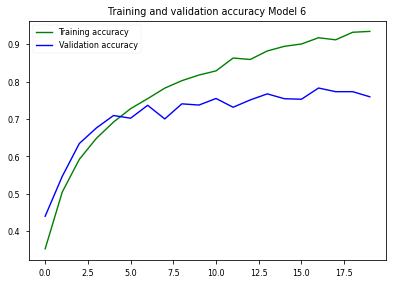

<Figure size 460.8x316.8 with 0 Axes>

In [271]:
acc= model_6.history.history
acc = model_6.history.history['accuracy']
val_acc = model_6.history.history['val_accuracy']
loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy Model 6')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_vgg16')
plt.show();

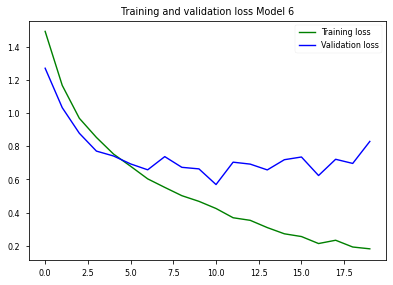

<Figure size 460.8x316.8 with 0 Axes>

In [273]:
acc= model_6.history.history
acc = model_6.history.history['accuracy']
val_acc = model_6.history.history['val_accuracy']
loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss Model 6')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_')
plt.show();

Tried model 6 again with 100 epochs instead of 20. To see if training longer makes any difference.

In [274]:
cnn_early_stop= [EarlyStopping(monitor='val_accuracy', patience= 15), 
                 ModelCheckpoint(filepath='/content/gdrive/My Drive/Capstone/best_models/', monitor='val_accuracy', save_best_only=True)]

In [275]:
model_6= prepare_model_6()
model_6.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=100, callbacks= cnn_early_stop)
            

Epoch 1/100
161/161 [==============================] - 12s 71ms/step - loss: 1.5517 - accuracy: 0.3321 - val_loss: 1.4091 - val_accuracy: 0.3943
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 2/100
161/161 [==============================] - 10s 64ms/step - loss: 1.2994 - accuracy: 0.4390 - val_loss: 1.1369 - val_accuracy: 0.5459
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 3/100
161/161 [==============================] - 11s 66ms/step - loss: 1.1183 - accuracy: 0.5178 - val_loss: 0.9581 - val_accuracy: 0.5979
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 4/100
161/161 [==============================] - 10s 65ms/step - loss: 0.9079 - accuracy: 0.6346 - val_loss: 0.8069 - val_accuracy: 0.6831
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 5/100
161/161 [==============================] - 11s 66ms/step - loss: 0.8102 - accuracy: 0.6564 - val_loss: 0.7638 - val_accuracy: 0.6871
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 6/100
161/161 [==============================] - 11s 69ms/step - loss: 0.6802 - accuracy: 0.7359 - val_loss: 0.7537 - val_accuracy: 0.7085
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 7/100
161/161 [==============================] - 11s 67ms/step - loss: 0.6320 - accuracy: 0.7450 - val_loss: 0.6340 - val_accuracy: 0.7482
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 8/100
161/161 [==============================] - 10s 65ms/step - loss: 0.5480 - accuracy: 0.7882 - val_loss: 0.6843 - val_accuracy: 0.7267
Epoch 9/100
161/161 [==============================] - 10s 62ms/step - loss: 0.4980 - accuracy: 0.8091 - val_loss: 0.6316 - val_accuracy: 0.7450
Epoch 10/100
161/161 [==============================] - 10s 64ms/step - loss: 0.4380 - accuracy: 0.8243 - val_loss: 0.7101 - val_accuracy: 0.7280
Epoch 11/100
161/161 [==============================] - 11s 69ms/step - loss: 0.4677 - accuracy: 0.8285 - val_loss: 0.6006 - val_accuracy: 0.7638
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 12/100
161/161 [==============================] - 11s 69ms/step - loss: 0.3683 - accuracy: 0.8529 - val_loss: 0.6571 - val_accuracy: 0.7424
Epoch 13/100
161/161 [==============================] - 11s 67ms/step - loss: 0.3302 - accuracy: 0.8695 - val_loss: 0.6618 - val_accuracy: 0.7521
Epoch 14/100
161/161 [==============================] - 10s 63ms/step - loss: 0.3006 - accuracy: 0.8870 - val_loss: 0.6118 - val_accuracy: 0.7690
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 15/100
161/161 [==============================] - 10s 64ms/step - loss: 0.2550 - accuracy: 0.9001 - val_loss: 0.6405 - val_accuracy: 0.7736
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 16/100
161/161 [==============================] - 10s 63ms/step - loss: 0.2404 - accuracy: 0.9008 - val_loss: 0.6754 - val_accuracy: 0.7885
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 17/100
161/161 [==============================] - 11s 69ms/step - loss: 0.2289 - accuracy: 0.9095 - val_loss: 0.6693 - val_accuracy: 0.7697
Epoch 18/100
161/161 [==============================] - 11s 69ms/step - loss: 0.2075 - accuracy: 0.9181 - val_loss: 0.7155 - val_accuracy: 0.7781
Epoch 19/100
161/161 [==============================] - 10s 66ms/step - loss: 0.1788 - accuracy: 0.9337 - val_loss: 0.7922 - val_accuracy: 0.7853
Epoch 20/100
161/161 [==============================] - 10s 64ms/step - loss: 0.1989 - accuracy: 0.9239 - val_loss: 0.7042 - val_accuracy: 0.7872
Epoch 21/100
161/161 [==============================] - 10s 63ms/step - loss: 0.1410 - accuracy: 0.9505 - val_loss: 0.8206 - val_accuracy: 0.7671
Epoch 22/100
161/161 [==============================] - 10s 63ms/step - loss: 0.1469 - accuracy: 0.9449 - val_loss: 0.8827 - val_accuracy: 0.7807
Epoch 23/100
161/161 [==============================] - 11s 69ms/step - loss: 0.1479 - accuracy: 0.9481 - val_loss: 0.8334 -

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 30/100
161/161 [==============================] - 10s 64ms/step - loss: 0.0849 - accuracy: 0.9673 - val_loss: 1.1075 - val_accuracy: 0.7430
Epoch 31/100
161/161 [==============================] - 10s 63ms/step - loss: 0.1309 - accuracy: 0.9566 - val_loss: 0.9191 - val_accuracy: 0.7866
Epoch 32/100
161/161 [==============================] - 11s 67ms/step - loss: 0.0869 - accuracy: 0.9660 - val_loss: 1.0794 - val_accuracy: 0.7625
Epoch 33/100
161/161 [==============================] - 11s 68ms/step - loss: 0.1004 - accuracy: 0.9644 - val_loss: 1.0419 - val_accuracy: 0.7677
Epoch 34/100
161/161 [==============================] - 11s 67ms/step - loss: 0.1332 - accuracy: 0.9551 - val_loss: 0.9930 - val_accuracy: 0.7788
Epoch 35/100
161/161 [==============================] - 10s 62ms/step - loss: 0.0904 - accuracy: 0.9705 - val_loss: 1.0181 - val_accuracy: 0.7781
Epoch 36/100
161/161 [==============================] - 11s 66ms/step - loss: 0.1073 - accuracy: 0.9630 - val_loss: 1.0610 -

In [276]:
print("The model training accurary is: ", (round(model_6.history.history['accuracy'][-1]*100,2)))
print("The model validation accurary is: ", (round(model_6.history.history['val_accuracy'][-1]*100,2)))

The best model training accurary is:  93.86
The best model validation accurary is:  78.72


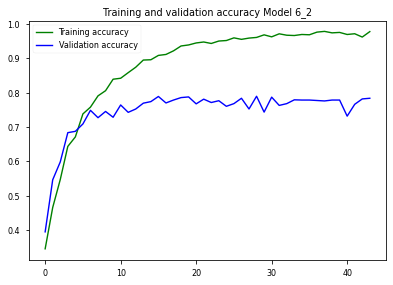

<Figure size 460.8x316.8 with 0 Axes>

In [277]:
acc= model_6.history.history
acc = model_6.history.history['accuracy']
val_acc = model_6.history.history['val_accuracy']
loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy Model 6_2')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_vgg16')
plt.show();

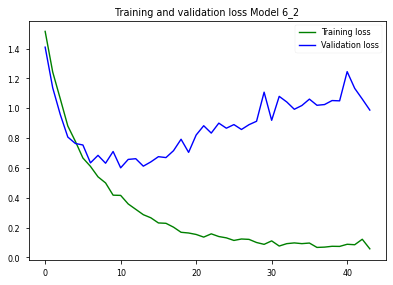

<Figure size 460.8x316.8 with 0 Axes>

In [278]:
acc= model_6.history.history
acc = model_6.history.history['accuracy']
val_acc = model_6.history.history['val_accuracy']
loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss Model 6_2')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_')
plt.show();

In an attempt to combat overfitting, we will use our model 6 on **augmented** images. And also increase the dropout regularization to 0.5. To do this we must create a seperate data generator so that the validation data is not also transformed.

IMAGE AUGMENTATIONS: 
- HorizontalFlip
- Contrast
- Brightness
- HueSaturationValue 
- ShiftScaleRotate




In [279]:
data_generator_aug= ImageDataGenerator(rescale= 1./255., validation_split=0.25, rotation_range=20, fill_mode='nearest', 
                                   width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, 
                                   brightness_range= [0.4, 1.2], zoom_range=[0.2,1.2])

In [280]:
train_generator= data_generator_aug.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category', subset= 'training', target_size=(128, 128),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category', subset= 'validation', target_size=(128,128),
     batch_size= 29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)


Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


In [281]:
def prepare_model_6():
  model= Sequential()
  #Layer 1
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu', input_shape= (128,128,3)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.5))
  #Layer 2
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.5))
  #Layer 3
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.5))
  #Layer 4
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  #Layer 5
  model.add(Dense(512, activation= 'relu'))
  #Layer 6
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model

In [282]:
model_6= prepare_model_6()
model_6.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=20, callbacks= cnn_early_stop
            
            )

Epoch 1/20
161/161 [==============================] - 30s 183ms/step - loss: 1.7393 - accuracy: 0.3314 - val_loss: 1.4783 - val_accuracy: 0.3338
Epoch 2/20
161/161 [==============================] - 30s 190ms/step - loss: 1.4572 - accuracy: 0.3556 - val_loss: 1.4654 - val_accuracy: 0.3669
Epoch 3/20
161/161 [==============================] - 30s 190ms/step - loss: 1.3724 - accuracy: 0.4156 - val_loss: 1.2766 - val_accuracy: 0.4314
Epoch 4/20
161/161 [==============================] - 29s 180ms/step - loss: 1.3387 - accuracy: 0.4331 - val_loss: 1.4602 - val_accuracy: 0.3611
Epoch 5/20
161/161 [==============================] - 30s 185ms/step - loss: 1.3028 - accuracy: 0.4458 - val_loss: 1.1783 - val_accuracy: 0.4964
Epoch 6/20
161/161 [==============================] - 29s 183ms/step - loss: 1.2551 - accuracy: 0.4739 - val_loss: 1.1587 - val_accuracy: 0.5036
Epoch 7/20
161/161 [==============================] - 30s 185ms/step - loss: 1.2032 - accuracy: 0.4927 - val_loss: 1.3996 - val_ac

In [283]:
print("The augmented model training accurary is: ", (round(model_6.history.history['accuracy'][-1]*100,2)))
print("The augmented model validation accurary is: ", (round(model_6.history.history['val_accuracy'][-1]*100,2)))

The augmented model training accurary is:  59.48
The augmented model validation accurary is:  62.65


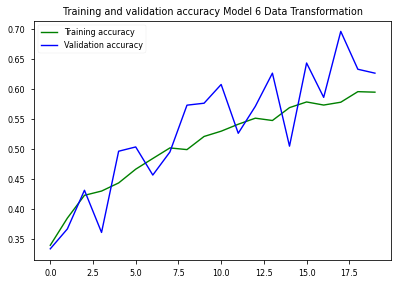

<Figure size 460.8x316.8 with 0 Axes>

In [284]:
acc= model_6.history.history
acc = model_6.history.history['accuracy']
val_acc = model_6.history.history['val_accuracy']
loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy Model 6 Data Transformation')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_vgg16')
plt.show();

This actually seems to have somewhat worked, val accuracy at one point was increasing steadly alongside training accuracy with each epoch. Unfortunately now the model seems to be underfitting.... -_-

##Using Pretrained Models

Lets give transfer learning an attempt to see if that can improve our accuracy.

###VGG16 Pretrained Model

To use the VGG16 model, we change our image shape to 128 instead of 64.

In [285]:
train_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category', subset= 'training', target_size=(128, 128),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category', subset= 'validation', target_size=(128,128),
     batch_size= 29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)

Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


In [286]:
vgg16= VGG16(input_shape= (128,128, 3), include_top= False, weights= 'imagenet')

for layer in vgg16.layers:
  layer.trainable=False

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [287]:

model = tf.keras.models.Sequential([
    vgg16,
    
    Flatten(),
    Dense(512,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
module_wrapper_24 (ModuleWra (None, 8192)              0         
_________________________________________________________________
module_wrapper_25 (ModuleWra (None, 512)               4194816   
_________________________________________________________________
module_wrapper_26 (ModuleWra (None, 512)               2048      
_________________________________________________________________
module_wrapper_27 (ModuleWra (None, 512)               0         
_________________________________________________________________
module_wrapper_28 (ModuleWra (None, 64)                32832     
_________________________________________________________________
module_wrapper_29 (ModuleWra (None, 64)               

In [288]:
model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [289]:
history= model.fit(train_generator, validation_data=validation_generator, epochs=10)


Epoch 1/10
162/162 [==============================] - 14s 80ms/step - loss: 1.1929 - accuracy: 0.5873 - val_loss: 0.7184 - val_accuracy: 0.7287
Epoch 2/10
162/162 [==============================] - 12s 75ms/step - loss: 0.7356 - accuracy: 0.7242 - val_loss: 0.6376 - val_accuracy: 0.7345
Epoch 3/10
162/162 [==============================] - 12s 75ms/step - loss: 0.5870 - accuracy: 0.7756 - val_loss: 0.5267 - val_accuracy: 0.8004
Epoch 4/10
162/162 [==============================] - 13s 79ms/step - loss: 0.5178 - accuracy: 0.8000 - val_loss: 0.6315 - val_accuracy: 0.7441
Epoch 5/10
162/162 [==============================] - 13s 81ms/step - loss: 0.4297 - accuracy: 0.8426 - val_loss: 0.4952 - val_accuracy: 0.8132
Epoch 6/10
162/162 [==============================] - 13s 78ms/step - loss: 0.3986 - accuracy: 0.8556 - val_loss: 0.6547 - val_accuracy: 0.7710
Epoch 7/10
162/162 [==============================] - 13s 80ms/step - loss: 0.3634 - accuracy: 0.8629 - val_loss: 0.6854 - val_accuracy:

After training our data on the VGG16 pretrained model we can see that our accuracy for both training and validation improves quickly, with respective accuracies at 88% and 79% and a lower validation loss. Its clearly overfitting less than others..This model is looking promising.

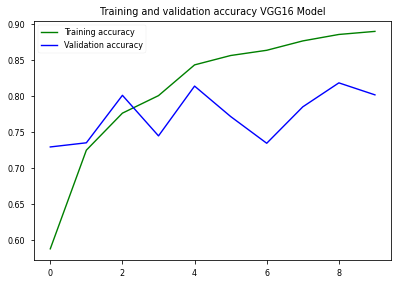

<Figure size 460.8x316.8 with 0 Axes>

In [290]:
acc= history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy VGG16 Model')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_vgg16')
plt.show();

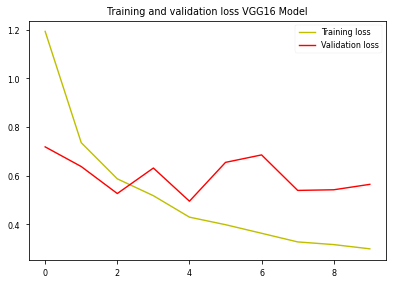

<Figure size 460.8x316.8 with 0 Axes>

In [291]:

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss VGG16 Model')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_loss_vgg16')
plt.show();

In [292]:
print("The VGG16 pretrained model training accurary is: ", (round(history.history['accuracy'][-1]*100,2)))
print("The VGG16 pretrained model validation accurary is: ", (round(history.history['val_accuracy'][-1]*100,2)))

The VGG16 pretrained model training accurary is:  88.91
The VGG16 pretrained model validation accurary is:  80.1


##Pretrained Model with Data Augmentation

In a final attempt to combat overfitting, we will use our pretrained VGG16 model on **augmented** images. To do this we must create a seperate data generator so that the validation data is not also transformed.

In [293]:
data_generator_aug= ImageDataGenerator(rescale= 1./255., validation_split=0.25, rotation_range=20, fill_mode='nearest', 
                                   width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, 
                                   brightness_range= [0.4, 1.2], zoom_range=[0.2,1.2])

In [294]:
train_generator= data_generator_aug.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category', subset= 'training', target_size=(128, 128),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category', subset= 'validation', target_size=(128,128),
     batch_size= 29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)


Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


Now we can train this augemented images on the pretrained model.

In [296]:
history_2= model.fit(train_generator, validation_data=validation_generator, epochs=30, callbacks=cnn_early_stop)


Epoch 1/30
162/162 [==============================] - 30s 188ms/step - loss: 1.0770 - accuracy: 0.5639 - val_loss: 0.5953 - val_accuracy: 0.7607
Epoch 2/30
162/162 [==============================] - 31s 193ms/step - loss: 1.0143 - accuracy: 0.5982 - val_loss: 0.5775 - val_accuracy: 0.7614
Epoch 3/30
162/162 [==============================] - 30s 186ms/step - loss: 0.9958 - accuracy: 0.6018 - val_loss: 0.5928 - val_accuracy: 0.7569
Epoch 4/30
162/162 [==============================] - 30s 186ms/step - loss: 0.9961 - accuracy: 0.5969 - val_loss: 0.5830 - val_accuracy: 0.7511
Epoch 5/30
162/162 [==============================] - 31s 190ms/step - loss: 0.9702 - accuracy: 0.6108 - val_loss: 0.5679 - val_accuracy: 0.7735
Epoch 6/30
162/162 [==============================] - 30s 183ms/step - loss: 0.9716 - accuracy: 0.6127 - val_loss: 0.5789 - val_accuracy: 0.7550
Epoch 7/30
162/162 [==============================] - 31s 191ms/step - loss: 0.9372 - accuracy: 0.6261 - val_loss: 0.5914 - val_ac

Didnt see any improve in val_loss after 15 epochs due to early stop parameter, so the model quit training.

In [300]:
print("The VGG16 pretrained model 2 training accurary is: ", (round(history_2.history['accuracy'][-1]*100,2)))
print("The VGG16 pretrained model 2 validation accurary is: ", (round(history_2.history['val_accuracy'][-1]*100,2)))

The VGG16 pretrained model 2 training accurary is:  64.26
The VGG16 pretrained model 2 validation accurary is:  74.28


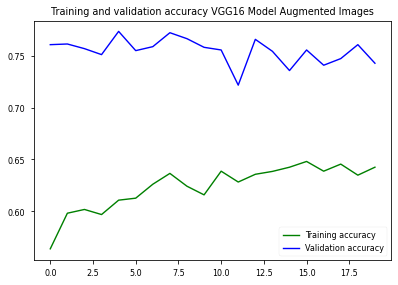

<Figure size 460.8x316.8 with 0 Axes>

In [303]:
acc= history_2.history
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy VGG16 Model Augmented Images')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_vgg16')
plt.show();

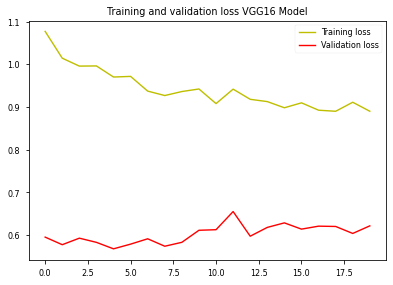

<Figure size 460.8x316.8 with 0 Axes>

In [304]:

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss VGG16 Model')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_loss_vgg16')
plt.show();

##Summary

 **What worked**


> In trying to improve the accuracy scores, the following seemed to make a difference, most of which is intuitive:

*   Add more layers
*   Adding stronger regularization (though not a huge improvement)
*   Using a pretrained model with established weights (VGG16)
*   Using a pretrained model on transformed images

 **What didnt work**

*   Training models for longer
*   But also not training models for long enough on transformed images.
*   Regularizing (when the dropout layers were not strong enough)












## Conclusions:


 **Overall**

 The best preforming model was the pretrained vgg16 model on non transformed images. With a training accuracy of 88% and a validation accuracy of 80% this model is the least overfit.
 

**Next Steps**
 

-Address Class Imbalances​

-Experiment with Other Pretrained Models​

-App Deployment 